In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb
import pickle
import imp
import datetime
from pprint import pprint
import utilities
imp.reload(utilities)


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV

#  Load data

In [6]:

'''    
file_name = 'data_for_modeling_25k.pkl'
with open('data/'+file_name, 'rb') as f:
    df = pickle.load(f)
'''

"    \nfile_name = 'data_for_modeling_25k.pkl'\nwith open('data/'+file_name, 'rb') as f:\n    df = pickle.load(f)\n"

In [2]:
def open_read( file_name, mode = '',df=''):
        if mode == 'w':
                with open('data/'+file_name, 'wb') as f:
                    pickle.dump(df, f)
        elif mode =='r':
                with open('data/'+file_name, 'rb') as f:
                    df = pickle.load(f)                
                return df
df = open_read('0.03_intermediate', mode = 'r')

In [8]:
df.columns

Index(['trip_duration', 'starttime', 'stoptime', 'ss_id', 'ss_name', 'ss_lat',
       'ss_lon', 'es_id', 'es_name', 'es_lat', 'es_lon', 'bike_id', 'usertype',
       'birth_year', 'gender', 'age', 'starttime_hour', 'starttime_month',
       'starttime_dayofweek', 'stoptime_hour', 'stoptime_month',
       'stoptime_dayofweek', 'stations_distance', 'route', 'trip_eff_speed'],
      dtype='object')

# Preprocessing

In [7]:
df['target'] = df['usertype'].apply(lambda x: 0 if x == 'Customer' else 1)
n_class_0 = df['target'].loc[df.target == 0].shape[0]
n_class_1 = df['target'].loc[df.target == 1].shape[0]

In [8]:
target = 'target'
cols_to_use = ['trip_eff_speed','stations_distance','trip_duration',
               'age', 'starttime_hour', 'starttime_month',
               'starttime_dayofweek', 'gender']
X = df[cols_to_use] 
y = df[target]

cols_to_scale = ['trip_duration','stations_distance',
                 'trip_eff_speed', 'age' ]
cols_to_encode = ['gender',  'starttime_month', 'starttime_hour', 'starttime_dayofweek']

assert (len(cols_to_use) == (len(cols_to_scale) + len(cols_to_encode))), 'Number of columns to scale and encode error'

for col in cols_to_scale:
    scaler = StandardScaler(with_mean = True, with_std = True)
    X[[col]] = scaler.fit_transform(X[[col]])

    
for col in cols_to_encode:
        X = pd.get_dummies(X, columns = [col], prefix = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
X_train.columns.sort

<bound method Index.sort of Index(['trip_eff_speed', 'stations_distance', 'trip_duration', 'age',
       'gender_0', 'gender_1', 'gender_2', 'starttime_month_1',
       'starttime_month_2', 'starttime_month_3', 'starttime_month_4',
       'starttime_month_5', 'starttime_month_6', 'starttime_month_7',
       'starttime_month_8', 'starttime_month_9', 'starttime_month_10',
       'starttime_month_11', 'starttime_month_12', 'starttime_hour_0',
       'starttime_hour_1', 'starttime_hour_2', 'starttime_hour_3',
       'starttime_hour_4', 'starttime_hour_5', 'starttime_hour_6',
       'starttime_hour_7', 'starttime_hour_8', 'starttime_hour_9',
       'starttime_hour_10', 'starttime_hour_11', 'starttime_hour_12',
       'starttime_hour_13', 'starttime_hour_14', 'starttime_hour_15',
       'starttime_hour_16', 'starttime_hour_17', 'starttime_hour_18',
       'starttime_hour_19', 'starttime_hour_20', 'starttime_hour_21',
       'starttime_hour_22', 'starttime_hour_23', 'starttime_dayofweek_0',
 

#  Modeling with basic parameters

In [55]:
clfs = [LogisticRegression(),
        GradientBoostingClassifier(),
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        MLPClassifier(hidden_layer_sizes = (16,32,32)),
        #SVC(probability = True)
   ]

names = ['Log. regr.', 'Grad. B.', 'R. f.', 'Dec. Tree', 'MLP']

results_overall = []
clf_nrs_for_importances = []
for i, clf in enumerate(clfs):
    
    print('Modeling :', str(clf.__class__))
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1] 
    #y_pred = clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    
    results = [str(clf.__class__),
               clf,
               roc_auc_score(y_test, y_pred),
               average_precision_score(y_test,y_pred),
               auc(recall, precision)]
               
    y_pred_train = clf.predict_proba(X_train)[:, 1]     
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, clf.predict_proba(X_train)[:,1])               
    
    results += [roc_auc_score(y_train, y_pred_train),
               average_precision_score(y_train, y_pred_train),auc(recall_train, precision_train)]
    results_overall.append(results)
               
    


Modeling : <class 'sklearn.linear_model.logistic.LogisticRegression'>
Modeling : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Modeling : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Modeling : <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Modeling : <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>


In [56]:
df = pd.DataFrame(data = results_overall, columns = ['name','clf','roc_test','avg_prec_test',
                                                'prec_auc_test','roc_train','avg_prec_train',
                                                'prec_auc_train'])
df.name = names
df.sort_values(['prec_auc_test'])[df.columns.difference(['clf'])]

,avg_prec_test,avg_prec_train,name,prec_auc_test,prec_auc_train,roc_test,roc_train
3,0.974550,1.000000,Dec. Tree,0.974550,1.000000,0.789124,1.000000
0,0.983384,0.983427,Log. regr.,0.983384,0.983427,0.902171,0.903719
2,0.985547,0.999979,R. f.,0.985547,0.999979,0.899595,0.999831
1,0.990116,0.990183,Grad. B.,0.990116,0.990183,0.937940,0.939869
4,0.990592,0.990948,MLP,0.990592,0.990948,0.940011,0.943282



__________________ 				 <class 'sklearn.linear_model.logistic.LogisticRegression'>


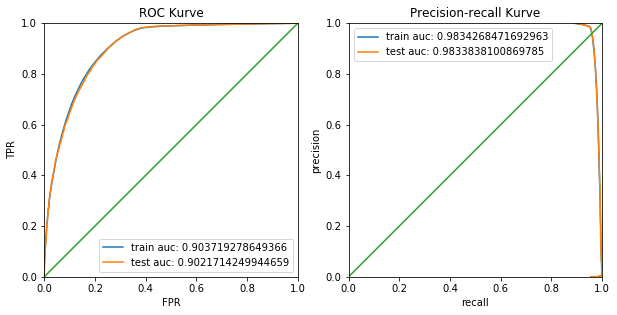


__________________ 				 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


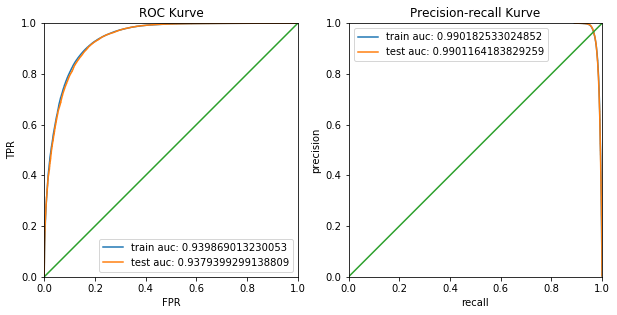


__________________ 				 <class 'sklearn.ensemble.forest.RandomForestClassifier'>


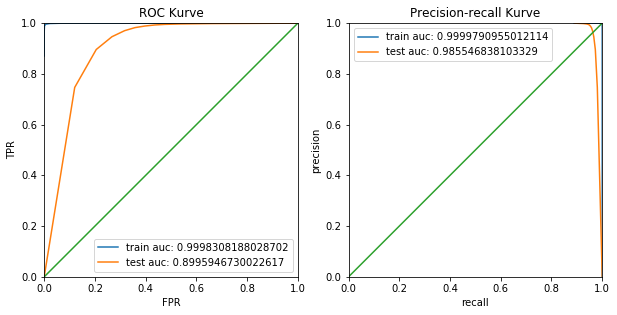


__________________ 				 <class 'sklearn.tree.tree.DecisionTreeClassifier'>


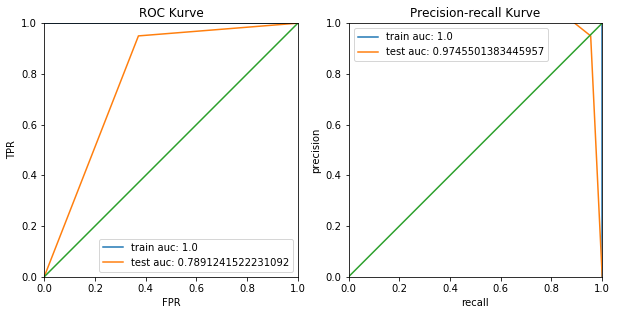


__________________ 				 <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>


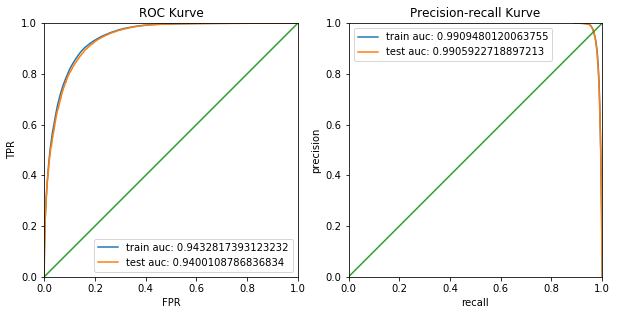

In [57]:
for item in results_overall:
    clf = item[1]
    utilities.setup_and_plot_model_scores(clf, X_test, y_test, X_train, y_train)

In [58]:
clf_nrs_for_importances = [2,3]
for i,item in enumerate(results_overall):
        if i in clf_nrs_for_importances:
            clf = item[1]
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]
            for f in range(X_train.shape[1]):
                print("{} feature {} ({}) column {}".format(f+1,
                                                            indices[f],
                                                            importances[indices[f]],
                                                            X_train.columns[indices[f]]
                                                           ))

1 feature 4 (0.2577823770369398) column gender_0
2 feature 3 (0.1497583701339126) column age
3 feature 2 (0.13602912185564214) column trip_duration
4 feature 0 (0.1296268325837951) column trip_eff_speed
5 feature 1 (0.09496150359966632) column stations_distance
6 feature 6 (0.03930456332398052) column gender_2
7 feature 5 (0.03069622401311743) column gender_1
8 feature 48 (0.007995429962043154) column starttime_dayofweek_5
9 feature 12 (0.006081466584162863) column starttime_month_6
10 feature 14 (0.0060256481601953255) column starttime_month_8
11 feature 15 (0.00570901151435962) column starttime_month_9
12 feature 13 (0.005573673003704328) column starttime_month_7
13 feature 16 (0.005422233634613898) column starttime_month_10
14 feature 11 (0.005385403529361557) column starttime_month_5
15 feature 49 (0.005243349281346994) column starttime_dayofweek_6
16 feature 36 (0.005117682384933866) column starttime_hour_17
17 feature 47 (0.005039192892583842) column starttime_dayofweek_4
18 feat

# Modeling with best-guess parameters

In [41]:
max_depth = 6
class_weight = {0:n_class_0, 1:n_class_1}
min_samples_split = 10
min_weight_fraction_leaf = 0.01

names = ['Log. regr.', 'Grad. B.', 'R. f.', 'Dec. Tree', 'MLP']
clfs = [LogisticRegression(class_weight = class_weight),
        GradientBoostingClassifier(max_depth = max_depth,
                                   random_state = 0,
                                   min_samples_split = min_samples_split,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf),
                                    
        RandomForestClassifier(n_estimators = 150,
                                max_depth = max_depth,
                                random_state = 0,
                                class_weight = class_weight,
                                min_samples_split = min_samples_split,
                                min_weight_fraction_leaf = min_weight_fraction_leaf),
        DecisionTreeClassifier(  max_depth = max_depth,
                                  random_state = 0,
                                  class_weight = class_weight,
                                  min_samples_split = min_samples_split,
                                  min_weight_fraction_leaf = min_weight_fraction_leaf),
        MLPClassifier(hidden_layer_sizes = (32,64,64)),
        #SVC(probability = True)
        
   ]
 
results_overall = []
clf_nrs_for_importances = []
for i, clf in enumerate(clfs):
    
    print('Modeling :', str(clf.__class__))
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1] 
    #y_pred = clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    
    results = [str(clf.__class__),
               clf,
               roc_auc_score(y_test, y_pred),
               average_precision_score(y_test,y_pred),
               auc(recall, precision)]
               
    y_pred_train = clf.predict_proba(X_train)[:, 1]     
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, clf.predict_proba(X_train)[:,1])               
    
    results += [roc_auc_score(y_train, y_pred_train),
               average_precision_score(y_train, y_pred_train),auc(recall_train, precision_train)]
    results_overall.append(results)
               

Modeling : <class 'sklearn.linear_model.logistic.LogisticRegression'>
Modeling : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Modeling : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Modeling : <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Modeling : <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>


In [42]:
df = pd.DataFrame(data = results_overall, columns = ['name','clf','roc_test','avg_prec_test',
                                                'prec_auc_test','roc_train','avg_prec_train',
                                                'prec_auc_train'])
df.sort_values(['prec_auc_test'])
df.name = names
df.sort_values(['prec_auc_test'])[df.columns.difference(['clf'])]

,avg_prec_test,avg_prec_train,name,prec_auc_test,prec_auc_train,roc_test,roc_train
0,0.980642,0.981005,Log. regr.,0.980642,0.981005,0.891307,0.892383
2,0.984607,0.984680,R. f.,0.984607,0.984680,0.912720,0.912619
3,0.985946,0.986042,Dec. Tree,0.985946,0.986042,0.914946,0.915343
4,0.989662,0.992484,MLP,0.989662,0.992484,0.936651,0.951024
1,0.990356,0.990892,Grad. B.,0.990356,0.990892,0.940614,0.942397


# Gridsearch I

In [63]:
old_time = datetime.datetime.now()
print(old_time)

parameters = {
    "min_samples_split": [4],
    "min_samples_leaf": [2],
    "max_depth":[3,6,9],
    "subsample":[0.85],
    "n_estimators":[75,100,150]}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=1, verbose= 2)
clf.fit(X_train, y_train)
new_time = old_time - datetime.timedelta(hours=2, minutes=10)
print(new_time)
print(clf.score(X_train, y_train))
print(clf.best_params_)

2019-07-08 07:50:09.062691
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85 
[CV]  min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85, total=  53.6s
[CV] min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.3s remaining:    0.0s


[CV]  min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85, total=  52.7s
[CV] min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85 
[CV]  min_samples_split=4, n_estimators=75, min_samples_leaf=2, max_depth=3, subsample=0.85, total=  53.9s
[CV] min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85 
[CV]  min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85, total= 1.2min
[CV] min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85 
[CV]  min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85, total= 1.1min
[CV] min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85 
[CV]  min_samples_split=4, n_estimators=100, min_samples_leaf=2, max_depth=3, subsample=0.85, total= 1.2min
[CV] min_samples_split=4, n_estimators=150, min_samples_leaf=2, max_depth=3, subsample=0.85

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 140.8min finished


2019-07-08 05:40:09.062691
0.950780389102
{'min_samples_split': 4, 'n_estimators': 75, 'min_samples_leaf': 2, 'max_depth': 6, 'subsample': 0.85}


In [64]:
results = []
for i,item in enumerate(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']-clf.cv_results_['mean_test_score'])):
    x = clf.cv_results_['params']
    x[i]['mean_test_score'] = item[0]
    x[i]['mean_score_delta'] = item[1]
    results.append(x)

pprint(sorted(x, key = lambda x: x['mean_test_score']), width = 600)    
    

[{'max_depth': 9, 'mean_score_delta': 0.016012700560022686, 'mean_test_score': 0.94769778090207846, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 150, 'subsample': 0.85},
 {'max_depth': 3, 'mean_score_delta': 0.00022086424460121545, 'mean_test_score': 0.94779277653227956, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 75, 'subsample': 0.85},
 {'max_depth': 3, 'mean_score_delta': 0.0002932983393119093, 'mean_test_score': 0.94804214006155718, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 0.85},
 {'max_depth': 9, 'mean_score_delta': 0.012627293723839417, 'mean_test_score': 0.94809913743967777, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 0.85},
 {'max_depth': 9, 'mean_score_delta': 0.010652571982054271, 'mean_test_score': 0.94826300490177451, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 75, 'subsample': 0.85},
 {'max_depth': 3, 'mean_score_delta': 0.0005664106041226579

#  Gridsearch II

In [65]:
old_time = datetime.datetime.now()
print(old_time)

parameters = {
    "learning_rate": [0.05, 0.1, 0.2],
    "min_samples_split": [10],
    "min_samples_leaf": [5],
    "max_depth":[6],
    "subsample":[0.85, 1],
    "n_estimators":[75]}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=1, verbose= 2)
clf.fit(X_train, y_train)
new_time = old_time - datetime.timedelta(hours=2, minutes=10)
print(new_time)
print(clf.score(X_train, y_train))
print(clf.best_params_)

2019-07-08 10:15:41.510867
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 
[CV]  subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6, total= 3.0min
[CV] subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV]  subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6, total= 3.0min
[CV] subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 
[CV]  subsample=0.85, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6, total= 3.0min
[CV] subsample=1, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 
[CV]  subsample=1, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6, total= 3.1min
[CV] subsample=1, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 
[CV]  subsample=1, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6, total= 3.1min
[CV] subsample=1, min_samples_leaf=5, n_estimators=75, learning_rate=0.05, min_samples_split=10, max_depth=6 
[CV]  subsample=1, min_samples_leaf=5, n_estimators

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 50.2min finished


2019-07-08 08:05:41.510867
0.950675893909
{'subsample': 0.85, 'min_samples_leaf': 5, 'n_estimators': 75, 'learning_rate': 0.1, 'min_samples_split': 10, 'max_depth': 6}


In [66]:
results = []
for i,item in enumerate(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']-clf.cv_results_['mean_test_score'])):
    x = clf.cv_results_['params']
    x[i]['mean_test_score'] = item[0]
    x[i]['mean_score_delta'] = item[1]
    results.append(x)

pprint(sorted(x, key = lambda x: x['mean_test_score']), width = 600) 

[{'learning_rate': 0.05, 'max_depth': 6, 'mean_score_delta': 0.0015056803179337441, 'mean_test_score': 0.94838412433028085, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 75, 'subsample': 1},
 {'learning_rate': 0.05, 'max_depth': 6, 'mean_score_delta': 0.0013857485575886619, 'mean_test_score': 0.94849811908652204, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 75, 'subsample': 0.85},
 {'learning_rate': 0.2, 'max_depth': 6, 'mean_score_delta': 0.0043223009762123343, 'mean_test_score': 0.94866436143937383, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 75, 'subsample': 0.85},
 {'learning_rate': 0.2, 'max_depth': 6, 'mean_score_delta': 0.0043258628611378969, 'mean_test_score': 0.94868811034692402, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 75, 'subsample': 1},
 {'learning_rate': 0.1, 'max_depth': 6, 'mean_score_delta': 0.0025066967204329105, 'mean_test_score': 0.94887572671657106, 'min_samples_leaf': 5, 'min_samples_s

#  Gridsearch III

In [67]:
old_time = datetime.datetime.now()
print(old_time)

parameters = {
    'loss' : ['deviance', 'exponential'],
    "learning_rate": [0.1],
    "min_samples_split": [30],
    "min_samples_leaf": [10],
    "max_depth":[6],
    "subsample":[1],
    "n_estimators":[75]}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=1, verbose= 2)
clf.fit(X_train, y_train)
new_time = old_time - datetime.timedelta(hours=2, minutes=10)
print(new_time)
#print(sorted(clf.cv_results_.items()))
print(clf.score(X_train, y_train))
print(clf.best_params_)

2019-07-08 11:10:33.887587
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6 
[CV]  subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6, total= 2.8min
[CV] subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV]  subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6, total= 2.8min
[CV] subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6 
[CV]  subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=deviance, min_samples_split=30, max_depth=6, total= 2.8min
[CV] subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=exponential, min_samples_split=30, max_depth=6 
[CV]  subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=exponential, min_samples_split=30, max_depth=6, total= 2.8min
[CV] subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=exponential, min_samples_split=30, max_depth=6 
[CV]  subsample=1, n_estimators=75, min_samples_leaf=10, learning_rate=0.1, loss=exponential, min_samples_split=30, max_depth=6, total= 2.8min
[CV] subsample=1, n_estimators=75, min_samples_leaf=1

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.9min finished


2019-07-08 09:00:33.887587
0.950010924497
{'subsample': 1, 'n_estimators': 75, 'min_samples_leaf': 10, 'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 30, 'max_depth': 6}


In [68]:
results = []
for i,item in enumerate(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']-clf.cv_results_['mean_test_score'])):
    x = clf.cv_results_['params']
    x[i]['mean_test_score'] = item[0]
    x[i]['mean_score_delta'] = item[1]
    results.append(x)

pprint(sorted(x, key = lambda x: x['mean_test_score']), width = 600) 

[{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 6, 'mean_score_delta': 0.002410513405149084, 'mean_test_score': 0.94884960291826581, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 75, 'subsample': 1}, {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 6, 'mean_score_delta': 0.0014154344805278329, 'mean_test_score': 0.9488923509518562, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 75, 'subsample': 1}]


# Finding optimum value for n_estimators

In [6]:
max_depth = 6
class_weight = {0:n_class_0, 1:n_class_1}
min_samples_split = 10
min_weight_fraction_leaf = 0.01

names = ['Grad. B.']
clfs = [GradientBoostingClassifier(max_depth = max_depth,
                                   random_state = 0,
                                   min_samples_split = min_samples_split,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf,
                                   n_estimators = 800)]
        

 
results_overall = []
clf_nrs_for_importances = []
for i, clf in enumerate(clfs):
    
    print('Modeling :', str(clf.__class__))
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1] 
    #y_pred = clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    
    results = [str(clf.__class__),
               clf,
               roc_auc_score(y_test, y_pred),
               average_precision_score(y_test,y_pred),
               auc(recall, precision)]
               
    y_pred_train = clf.predict_proba(X_train)[:, 1]     
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, clf.predict_proba(X_train)[:,1])               
    
    results += [roc_auc_score(y_train, y_pred_train),
               average_precision_score(y_train, y_pred_train),auc(recall_train, precision_train)]
    results_overall.append(results)
               

Modeling : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


In [7]:
errors_train = [mean_squared_error(y_train, y_pred) for y_pred in clf.staged_predict(X_train)]
errors_test = [mean_squared_error(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]

roc_auc_scores_train = [roc_auc_score(y_train, y_pred) for y_pred in clf.staged_predict(X_train)]
roc_auc_scores_test = [roc_auc_score(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]

auc_differences = np.subtract(roc_auc_scores_train, roc_auc_scores_test)

Optimal number of estimators: 153


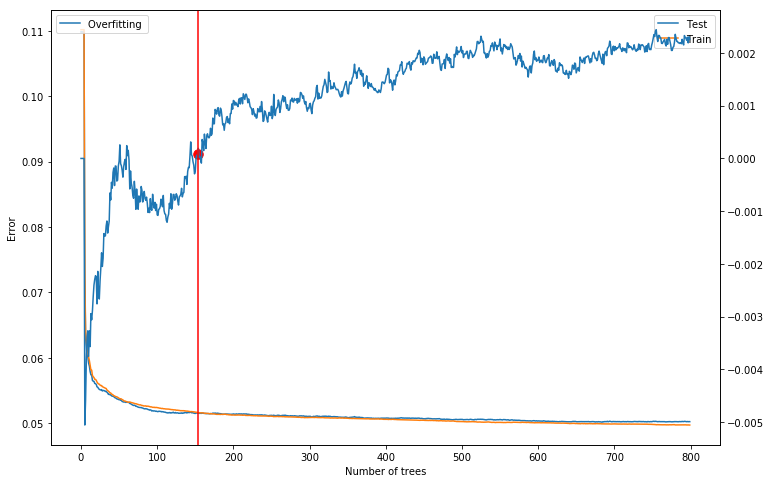

In [30]:
fig, ax = plt.subplots(figsize = (12,8))
x = [i for i in range(len(errors_test))]
ax.plot(x, errors_test, label = 'Test')
ax.plot(x, errors_train, label = 'Train')
ax2 = ax.twinx()
ax2.plot(x, auc_differences, label = 'Overfitting ')
np.multiply(auc_differences,auc_differences)


ms_overfit = np.sqrt(np.multiply(auc_differences[5:],auc_differences[5:]))
min_overfit_index = np.argmin(ms_overfit)+5
ax2.scatter( min_overfit_index,ms_overfit[min_overfit_index], color = 'red',s = 90)
ax2.axvline(min_overfit_index,ms_overfit[min_overfit_index], color = 'red')

ax.set_xlabel('Number of trees')
ax.set_ylabel('Error')
ax.legend()
ax2.legend()

print('Optimal number of estimators: {}'.format(min_overfit_index))
plt.show()


In [43]:
names = ['Grad. B.']
clfs = [GradientBoostingClassifier(max_depth = 6,
                                   learning_rate = 0.1,
                                   min_samples_split = 10,
                                   min_weight_fraction_leaf = 0.01,
                                   n_estimators = 153)]
        

 
results_overall = []
clf_nrs_for_importances = []
for i, clf in enumerate(clfs):
    
    print('Modeling :', str(clf.__class__))
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1] 
    #y_pred = clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    
    results = [str(clf.__class__),
               clf,
               roc_auc_score(y_test, y_pred),
               average_precision_score(y_test,y_pred),
               auc(recall, precision)]
               
    y_pred_train = clf.predict_proba(X_train)[:, 1]     
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, clf.predict_proba(X_train)[:,1])               
    
    results += [roc_auc_score(y_train, y_pred_train),
               average_precision_score(y_train, y_pred_train),auc(recall_train, precision_train)]
    results_overall.append(results)
               

Modeling : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


In [44]:
df = pd.DataFrame(data = results_overall, columns = ['name','clf','roc_test','avg_prec_test',
                                                'prec_auc_test','roc_train','avg_prec_train',
                                                'prec_auc_train'])
df.sort_values(['prec_auc_test'])
df.name = names
df.sort_values(['prec_auc_test'])[df.columns.difference(['clf'])]

,avg_prec_test,avg_prec_train,name,prec_auc_test,prec_auc_train,roc_test,roc_train
0,0.990509,0.991197,Grad. B.,0.990509,0.991197,0.941429,0.943929


###  Ensemble classifiers

In [ ]:
max_depth = 6
class_weight = {0:n_class_0, 1:n_class_1}
min_samples_split = 10
min_weight_fraction_leaf = 0.01

clf1 = LogisticRegression(class_weight = class_weight)


                                    
clf2 = RandomForestClassifier(n_estimators = 150,
                                max_depth = max_depth,
                                random_state = 0,
                                class_weight = class_weight,
                                min_samples_split = min_samples_split,
                                min_weight_fraction_leaf = min_weight_fraction_leaf)

clf3 = DecisionTreeClassifier(  max_depth = max_depth,
                                  random_state = 0,
                                  class_weight = class_weight,
                                  min_samples_split = min_samples_split,
                                  min_weight_fraction_leaf = min_weight_fraction_leaf)

clf4 = MLPClassifier(hidden_layer_sizes = (32,64,64))
        
   
clf5 = GradientBoostingClassifier(max_depth = 6,
                                   learning_rate = 0.1,
                                   min_samples_split = 10,
                                   min_weight_fraction_leaf = 0.01,
                                   n_estimators = 153)

# (estimators, voting=’hard’, weights=None, n_jobs=None, flatten_transform=True)
clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('dt', clf3),('mlp', clf4), ('gb', clf5)],
         voting='soft')

clf = clf.fit(X_train, y_train)

In [14]:
results_overall = []
y_pred = clf.predict_proba(X_test)[:, 1] 
#y_pred = clf.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

results = [str(clf.__class__),
           clf,
           roc_auc_score(y_test, y_pred),
           average_precision_score(y_test,y_pred),
           auc(recall, precision)]

y_pred_train = clf.predict_proba(X_train)[:, 1]     
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, clf.predict_proba(X_train)[:,1])               

results += [roc_auc_score(y_train, y_pred_train),
           average_precision_score(y_train, y_pred_train),auc(recall_train, precision_train)]
results_overall.append(results)

In [16]:
df = pd.DataFrame(data = results_overall, columns = ['name','clf','roc_test','avg_prec_test',
                                                'prec_auc_test','roc_train','avg_prec_train',
                                                'prec_auc_train'])
df.sort_values(['prec_auc_test'])
df.name = 'Ensemble'
df.sort_values(['prec_auc_test'])[df.columns.difference(['clf'])]

,avg_prec_test,avg_prec_train,name,prec_auc_test,prec_auc_train,roc_test,roc_train
0,0.990396,0.991627,Ensemble,0.990396,0.991627,0.940493,0.946589
